In [1]:
import preprocessing_pipeline as pp
import mne
import numpy as np
import pickle

In [2]:
def load_raw_data(path):
    raw = pp.load_eeg_data(path, eeg_format="cnt", use_montage_creator=True, montage_type='standard_1020')
    raw = pp.add_stimulus_to_raw(raw)
    raw = pp.bandpass_filter(raw)
    raw = pp.average_rereference(raw)
    # Step 7: ICA decomposition and removal of artifacts
    ica_tool = pp.ICAChannelSelection(n_component=20, data=raw)  # You may adjust `n_component` based on your needs.
    ica_tool.fit_ica()

    # Identify and label artifact components
    combined_artifacts = ica_tool.find_combined_artifacts()
    events = mne.find_events(raw, stim_channel='STI')
    return raw, events

In [3]:
def get_need_to_search_event_times(events):
    #Load in the IDs specific to word displays, as well as NeedToSearch conditional IDs
    NeedToSearchIDs = [21,22,23,24,25,26,27,28,29,30,31,32,33,6,9]
    events_times = mne.pick_events(events,include=NeedToSearchIDs)
    events_times = np.where(events_times == 6, 34, events_times) #Change 6 & 9 to 34 & 35 to allow loop to run
    events_times = np.where(events_times == 9, 35, events_times)

    #Segment all trials into lists of events
    event_sequence_list = []
    event_sequence = []
    event_id_max = 0
    for x in events_times:
        event_info = x
        event_id = event_info[2]
        #print(event_id_max)
        if event_id > event_id_max:
            event_id_max = event_id
            event_sequence.append(event_info)
        else:
            event_sequence_list.append(event_sequence)
            event_sequence = []
            event_id_max = 0

    #Find all trials that contain both 34 and 35 e.g. NeedToSearch conditions
    NeedToSearchEventTimes = []
    for x in event_sequence_list:
        event_sequence = x
        value_present = any(34 and 35 in array for array in event_sequence)
        if value_present:
            NeedToSearchEventTimes.append(event_sequence)

    return NeedToSearchEventTimes



In [4]:
def get_eeg_time_segments(raw, NeedToSearchEventTimes):
    sample_rate = 500 #TODO - get this from raw
    eeg_time_segments = []
    for x in NeedToSearchEventTimes:
        start_index = x[2][0]
        end_index = int(start_index + (0.8*sample_rate))
        cropped_data = raw[:, start_index:end_index]
        eeg_time_segments.append(cropped_data)
    return eeg_time_segments

Reading 0 ... 3507399  =      0.000 ...  7014.798 secs...


C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Data\preprocessing_pipeline.py:137: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(file, preload=preload)
C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Data\preprocessing_pipeline.py:53: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  self.raw.set_montage(montage)


Creating RawArray with float64 data, n_channels=1, n_times=3507400
    Range : 0 ... 3507399 =      0.000 ...  7014.798 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.25 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.1s


Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=4)]: Done  34 out of  34 | elapsed:    7.2s finished


Fitting ICA to data using 34 channels (please be patient, this may take a while)
Selecting by number: 20 components


C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Data\preprocessing_pipeline.py:291: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (22) and smallest (8.2e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  self.ica.fit(self.data)


Fitting ICA took 76.9s.
Error while processing ECG artifact: Unable to generate artificial ECG channel
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


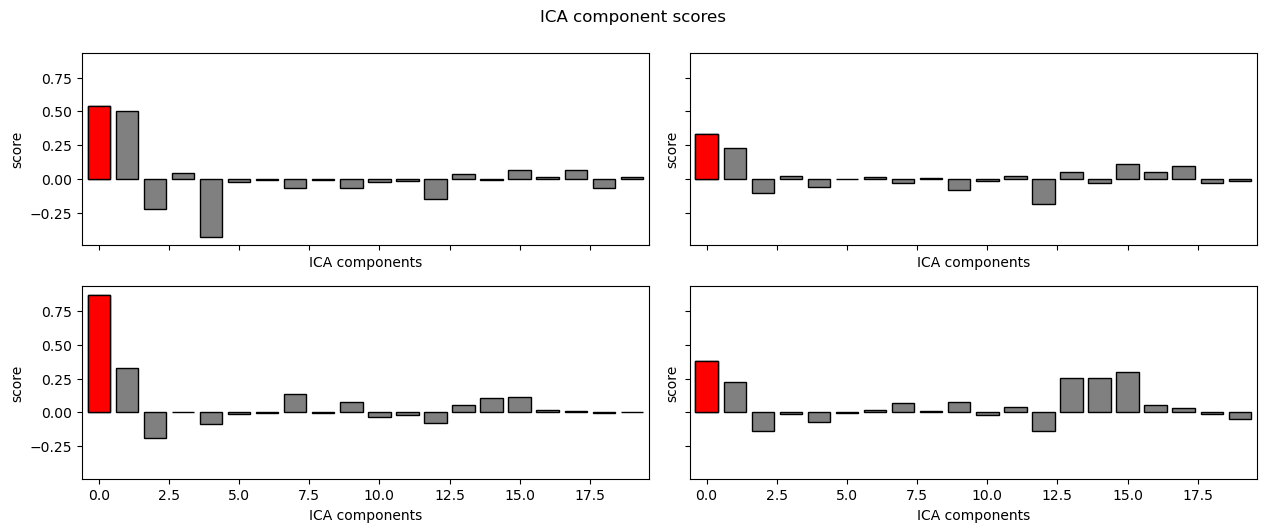

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated


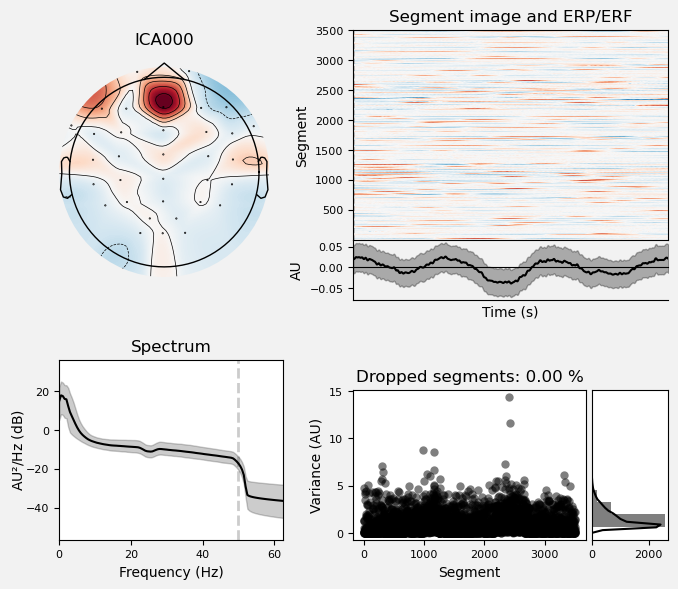

Creating RawArray with float64 data, n_channels=24, n_times=3507400
    Range : 0 ... 3507399 =      0.000 ...  7014.798 secs
Ready.
Using matplotlib as 2D backend.


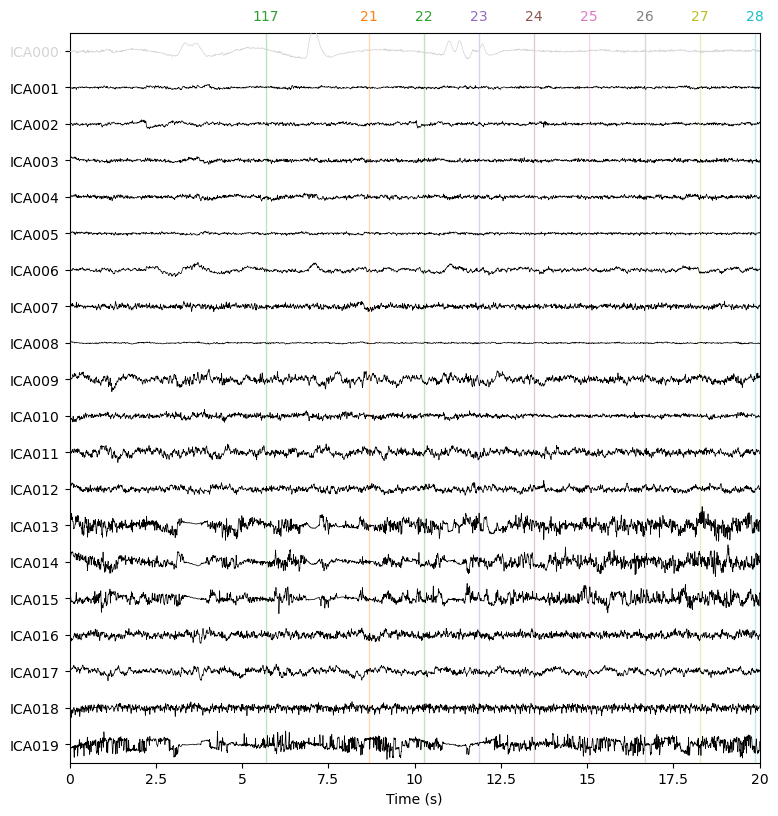

Effective window size : 0.512 (s)


KeyboardInterrupt: 

<Figure size 640x270 with 0 Axes>

In [5]:
ParticipantList = ["01", "02", "03", "04", "05", "06", "08", "09", "10",
                   "11", "12", "13", "14", "15", "16", "18", "19", "20",
                   "21", "22", "23", "24"]

for participant_number in ParticipantList:
    path = fr"I:\Science\CIS-YASHMOSH\niallmcguire\dominika\Raw Data\0{participant_number}\0{participant_number}.cnt"
    raw, events = load_raw_data(path)
    NeedToSearchEventTimes = get_need_to_search_event_times(events)
    NeedToSearchEEGSegments = get_eeg_time_segments(raw, NeedToSearchEventTimes)
    pickle_file_path = fr'C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\EEG-NeedToSearch-DataSegments\participant_0{participant_number}_EEG_data.pkl'

    # Open the file in binary write mode and use pickle.dump to save the data
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump(NeedToSearchEEGSegments, pickle_file)


In [ ]:
'''
# Specify the file path where you saved the pickle file
pickle_file_path = 'your_file_path.pkl'

# Open the file in binary read mode and use pickle.load to load the data
with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

# Now 'loaded_data' contains the data structure you saved
'''